# Importing the necessary modules

In [2]:
import pandas as pd

In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy


# Segmenting the sentences

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Loading the data set

In [6]:
df = pd.read_csv("data.txt", delimiter = '.', header = None)


df.to_csv("data.csv")
df = pd.read_csv("data.csv")
df = df.T
df.columns = ['Sentence']
df.shape
df

,Sentence
Unnamed: 0,0
0,"Paracetamol, also known as acetaminophen,is a medication used to treat fever and mild to moderate pain"
1,Common brand names include Tylenol and Panadol
2,"At a standard dose, paracetamol only slightly decreases body temperature; it is inferior to ibuprofen in that respect, and the benefits of its use for fever are unclear"
3,Paracetamol may relieve pain in acute mild migraine but only slightly in episodic tension headache
4,"However, the aspirin/paracetamol/caffeine combination helps with both conditions where the pain is mild and is recommended as a first-line treatment for them"
5,"Paracetamol is effective for post-surgical pain, but it is inferior to ibuprofen"
6,The paracetamol/ibuprofen combination provides further increase in potency and is superior to either drug alone
7,The pain relief paracetamol provides in osteoarthritis is small and clinically insignificant
8,"The evidence in its favor for the use in low back pain, cancer pain, and neuropathic pain is insufficient"


In [7]:
test = nlp("Paracetamol, also known as acetaminophen, is a medication used to treat fever and mild to moderate pain. Common brand names include Tylenol and Panadol.")

for token in test:
    print(token.text, "...", token.dep_)

Paracetamol ... nsubj
, ... punct
also ... advmod
known ... acl
as ... prep
acetaminophen ... pcomp
, ... punct
is ... ROOT
a ... det
medication ... attr
used ... acl
to ... aux
treat ... xcomp
fever ... dobj
and ... cc
mild ... amod
to ... aux
moderate ... amod
pain ... conj
. ... punct
Common ... amod
brand ... compound
names ... nsubj
include ... ROOT
Tylenol ... dobj
and ... cc
Panadol ... conj
. ... punct


# Extracting the entities

In [8]:
def entity_extrct(st):
    ent1 = ""
    ent2 = ""
    
    dep_prev = ""
    tok_prev = ""
    
    prefix = ""
    modifier = ""
    
    for token in nlp(st):
    
        if token.dep_ != "punc":  # if the token is a punctuation we ignore
        
            if token.dep_ == "compound": 
                prefix = token.text
            
                if dep_prev == "compound":
                    prefix = tok_prev + " " + token.text
                
     # if the token is a modifier or not
            if token.dep_.endswith("mod") == True:
                modifier = token.text
        # if the previous word was also a 'compound' then we add the current word to it
                if dep_prev == "compound":
                    modifier = tok_prev + " "+ token.text
                
            if token.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ token.text
                prefix = ""
                modifier = ""
                dep_prev = ""
                tok_prev = ""      

        if token.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ token.text
        
    dep_prev = token.dep_
    tok_prev = token.text
    
    return [ent1.strip(), ent2.strip()]
                
        

# Extracting the relations

In [9]:
def extract_relation(st):
    doc = nlp(st)

  # Matcher class object 
    matcher = Matcher(nlp.vocab)

  #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

# Output

In [10]:
op = []
lt = []
for element in df['Sentence']:
    if isinstance(element, str):
        lt = entity_extrct(element)
        lt.insert(1, extract_relation(element))
        op.append(lt)
op


[['Paracetamol', 'is', 'also  fever'],
 ['Common brand names', 'include', 'Tylenol'],
 ['benefits', 'is inferior', 'fever'],
 ['Paracetamol', 'relieve', 'episodic tension headache'],
 ['where  pain', 'helps with', 'first line them'],
 ['surgical  it', 'is effective', 'surgical  pain'],
 ['paracetamol ibuprofen combination', 'provides further', 'further  drug'],
 ['provides', 'is small', 'osteoarthritis'],
 ['evidence', 'is insufficient', 'low back pain'],
 ['abdominal  it', 'are', 'tolerability'],
 ['Chronic  consumption', 'result in', 'gastrointestinal hemoglobin bleeding'],
 ['', 'is', 'higher  paracetamol'],
 ['drug', 'increase', 'developing  hypertension'],
 ['is', 'observed in', 'true  increase'],
 ['causal which', 'suggest', 'possible  time'],
 ['daily  dose', 'is', 'adult'],
 ['Higher  doses', 'lead to', 'liver failure'],
 ['Paracetamol poisoning', 'is', 'most United States'],
 ['Paracetamol', 'made in', 'first  1877'],
 ['It', 'is', 'used United States'],
 ['It', 'is on', 'Esse

# Graph visualisation

In [11]:
source = [i[0] for i in op]

# extract relation
relation = [i[1] for i in op]

target = [i[2] for i in op] 

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})


In [12]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

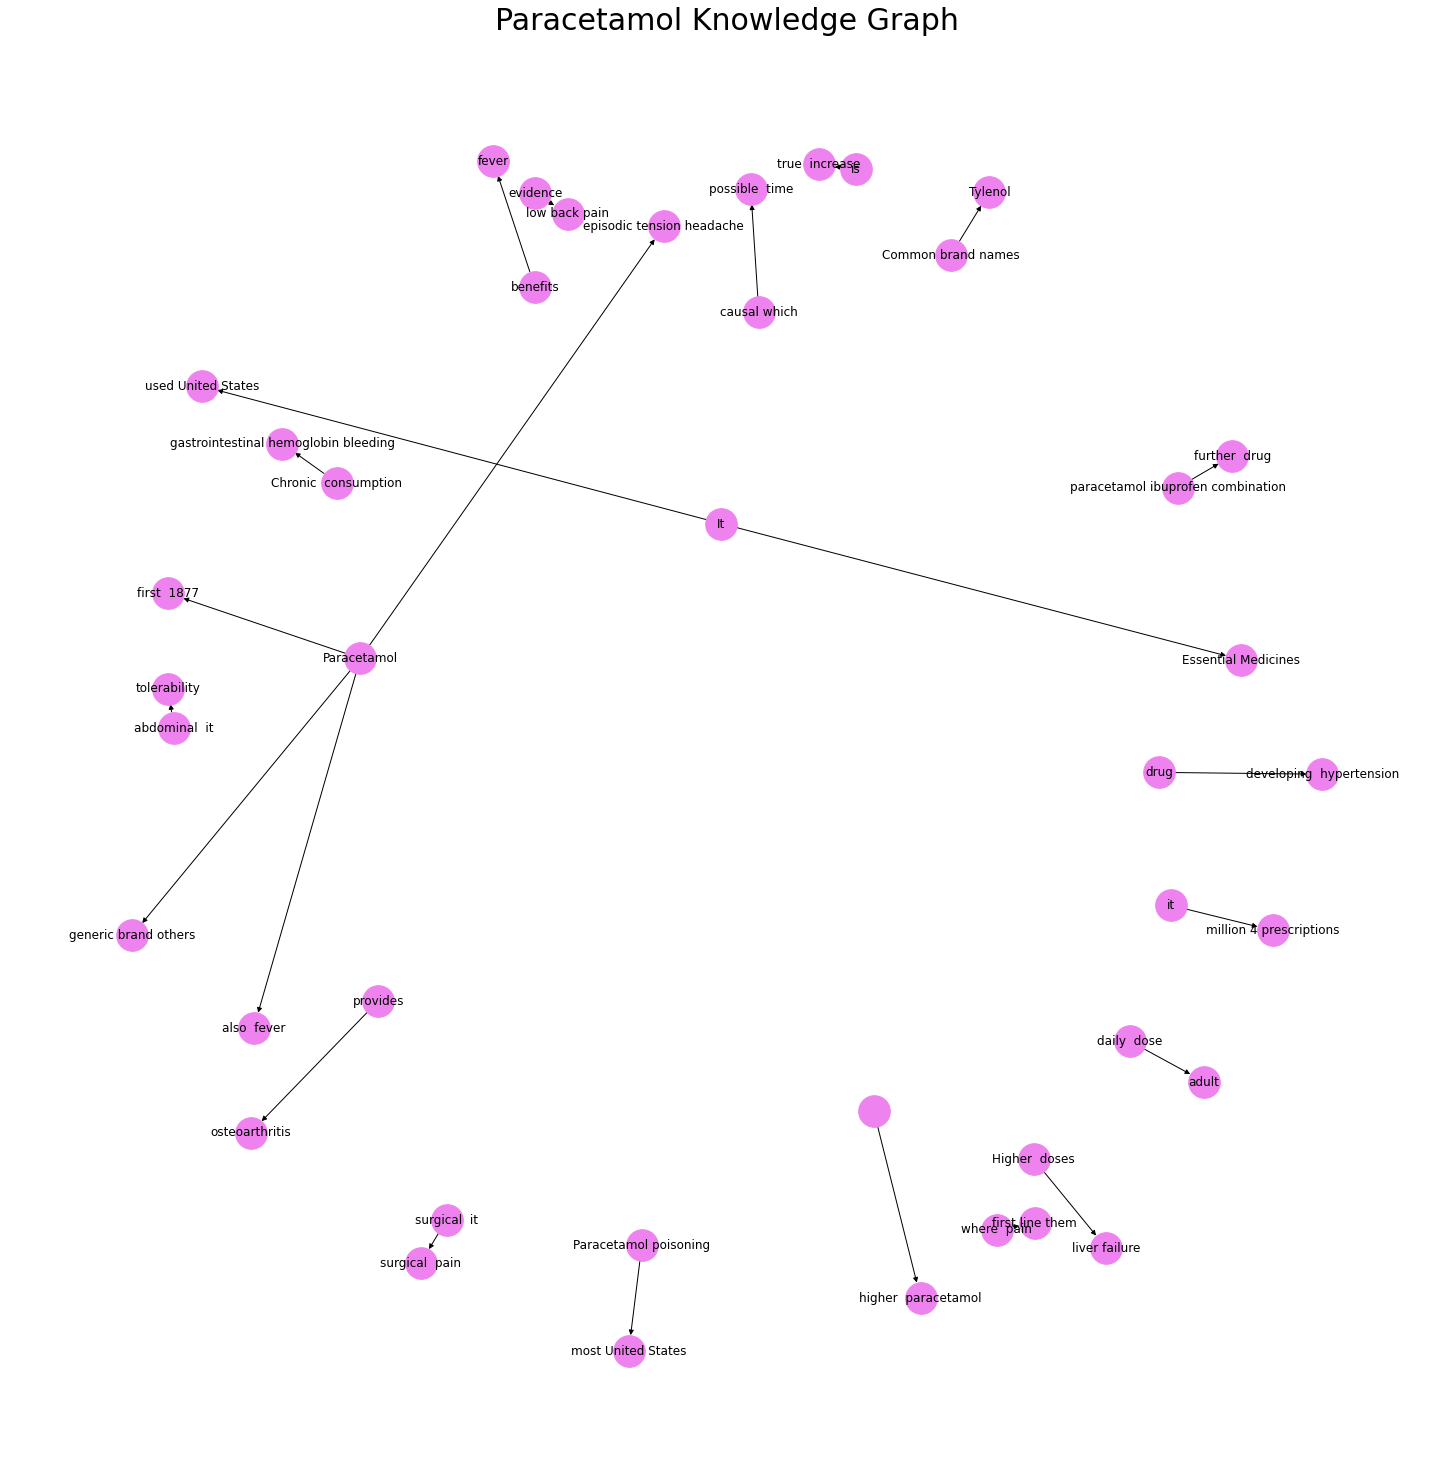

In [13]:
plt.figure(figsize=(20,20))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='violet', node_size = 1000, edge_cmap=plt.cm.Blues, pos = pos)

plt.title("Paracetamol Knowledge Graph", fontsize = 30)
plt.show()